In [1]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [3]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 100 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100
GLOVE_DIR = r"glove.twitter.27B.100d.txt"

In [7]:
import os 
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DATASET AML/')

Mounted at /content/drive


# Import Glove

In [8]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")


Loading GloVe from: glove.twitter.27B.100d.txt ...Done.
 Proceeding with Embedding Matrix...

Mounted at /content/drive


#Import Dataset

EDA BINARY

In [9]:
os.chdir('/content/drive/My Drive/DATASET AML/PROJECT/dataset_giusti')

In [10]:
train = pd.read_csv("MULTILABEL_augmented_EDA_senza_stopword_FINAL.csv")
train["comment_text"] = train["comment_text"].astype(str)
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,well u say really hurt u block bitch tit ur pu...,1,1,1,0,1,0
1,dont know think cocksucker whole load shite ph...,1,1,1,0,1,0
2,robert palmer respect intend binknsternet kiss...,1,0,1,0,1,0
3,keep head man not let uppity bitch get man one...,1,0,1,0,1,0
4,naked mum sex indeed faggot suck tour dad cock...,1,1,1,0,1,1


#Tokenization and Embedding

In [11]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train['comment_text'].values)
sequences = tokenizer.texts_to_sequences(train["comment_text"])
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 32510


In [12]:
embeddings_dict = {}

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_dict[word] = embedding_vector
print(" Completed!")

 Completed!


In [13]:
tsne = TSNE(n_components=2, random_state=0)
words =  list(embeddings_dict.keys())
vectors = [embeddings_dict[word] for word in words]

In [14]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [15]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

In [16]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (23181, 100)
Shape of label tensor: (23181, 6)


In [17]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [18]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [17581  4527 11343  1483 10882  4001]
validation:  [4405 1108 2806  371 2671 1036]


In [19]:
print('Tokenized sentences: \n', data[20])
print('One hot label: \n', labels[20])

Tokenized sentences: 
 [306   9  10   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
One hot label: 
 [1 0 0 0 1 1]


In [20]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

 Completed!


#LSTM MODEL

In [23]:
from tensorflow.keras.layers import Bidirectional
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
import keras

In [27]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = (Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer')))(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

In [28]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = [tf.keras.metrics.Recall()])

In [29]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 4, batch_size=128, validation_data=(x_val, y_val), verbose = 2)

Training progress:
Epoch 1/4
145/145 - 10s - loss: 0.4320 - recall_1: 0.7578 - val_loss: 0.3625 - val_recall_1: 0.7764
Epoch 2/4
145/145 - 5s - loss: 0.3494 - recall_1: 0.7989 - val_loss: 0.3303 - val_recall_1: 0.8170
Epoch 3/4
145/145 - 5s - loss: 0.3222 - recall_1: 0.8230 - val_loss: 0.3159 - val_recall_1: 0.8321
Epoch 4/4
145/145 - 5s - loss: 0.3063 - recall_1: 0.8383 - val_loss: 0.3032 - val_recall_1: 0.8344


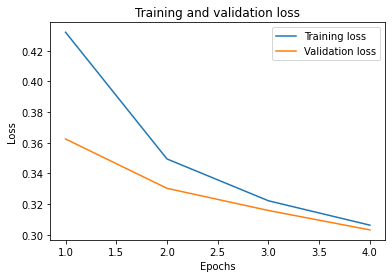

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

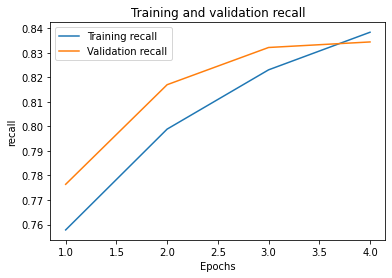

In [33]:
accuracy = history.history['recall_1']
val_accuracy = history.history['val_recall_1']
plt.plot(epochs, accuracy, label='Training recall')
plt.plot(epochs, val_accuracy, label='Validation recall')
plt.title('Training and validation recall')
plt.ylabel('recall')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Test

In [34]:
os.chdir('/content/drive/My Drive/DATASET AML/PROJECT/dataset_giusti/TEST')

In [35]:
test = pd.read_csv("test_multilabel_senza_stopword.csv")

In [36]:
test

,Unnamed: 0,Unnamed: 0.1,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,8,21,arab commit genocide iraq protest europe may e...,1,0,0,0,0,0
1,24,48,dj robinson gay hell suck dick much,1,0,1,0,1,1
2,29,59,fuck antisemitic cunt,1,0,1,0,1,0
3,38,76,dare vandalize page hm beagle not vandalize demon,1,0,0,0,0,0
4,40,81,arrogant self serve immature idiot get right,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
6238,63877,152908,nigel crazy idiot,1,0,0,0,1,0
6239,63935,153049,well not feel stupid,0,0,0,0,1,0
6240,63945,153078,fourth baldrick possibly cleverer make anyone ...,1,0,0,0,0,0
6241,63962,153119,iran thats right iran drone spread homosexual ...,1,0,1,0,0,0


In [37]:

sequences = tokenizer.texts_to_sequences(test["comment_text"].astype(str))


In [38]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [39]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = test[labels].values

In [40]:
eval= model.evaluate(data,y)

196/196 [==============================] - 3s 17ms/step - loss: 0.2753 - recall_1: 0.8291


In [41]:
performance = model.predict(data)


In [42]:
import sklearn
y_pred =np.round(performance)
print("RECALL: ", sklearn.metrics.recall_score(y, y_pred, average= 'weighted'))
print("PRECISION: ",sklearn.metrics.precision_score(y, y_pred, average= 'weighted'))
print("F1-SCORE: ",sklearn.metrics.f1_score(y, y_pred, average= 'weighted'))



mat =sklearn.metrics.multilabel_confusion_matrix(y,y_pred)
accuracy=[]
for i in range(mat.shape[0]):

  accuracy.append((mat[i][1][1]+mat[i][0][0])/(mat[i][1][1]+mat[i][0][0]+mat[i][0][1]+mat[i][1][0]))

def Average(lst): 
    return sum(lst) / len(lst) 

accuracy_media =  Average(accuracy) 
print("ACCURACY: ",accuracy_media)

RECALL:  0.8290798730859429
PRECISION:  0.8486377176734617
F1-SCORE:  0.8371374871057221
ACCURACY:  0.8747664050403118
